In [1]:
from unicodedata import decimal

import li.analysis as la
import li.visualize as vi
import li.EvaluationHelpers as eh
import li.diagnostic as diagnostic

import os
import seaborn
import numpy as np
import pandas as pd
from PIL import Image # for reading images
import scipy.constants as const
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams

rcParams['font.family'] = 'Helvetica'

# Data Loading and Definition of Variables

In [2]:
# date = "20250306"
# images_set = "D-effMass_810G_Bragg"
# path_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + images_set + "/"
# path_file = os.listdir(path_dir)

date = "20250219"
images_set = "F-balance_heated_Spectrum"
path_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + images_set + "/"
path_file = os.listdir(path_dir)

# ref_set = "D-effMass_810G_zeroResp"
# ref_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + ref_set + "/"
# ref_file = os.listdir(ref_dir)

print(len(path_file))
print(path_file[-1])

12655
ReinaudiSave_i_2_FB_12_820_Acc_heat_freq_6000.png


In [3]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[0])[1]
var_vals = la.loop_variables(path_dir + path_file[0])[0]

# ref_variables = la.loop_variables(ref_dir + ref_file[0])[1]
# ref_var_vals = la.loop_variables(ref_dir + ref_file[0])[0]

print(f"{images_set}")
for i, var in enumerate(variables):
    print(f"{var}: {var_vals[i][0]} - {var_vals[i][-1]}")

print("")

# print(f"{ref_set}")
# for i, var in enumerate(ref_variables):
#     print(f"{var}: {ref_var_vals[i][0]} - {ref_var_vals[i][-1]}")

In [5]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[-1])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [6]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 109 ms
Wall time: 1.22 s


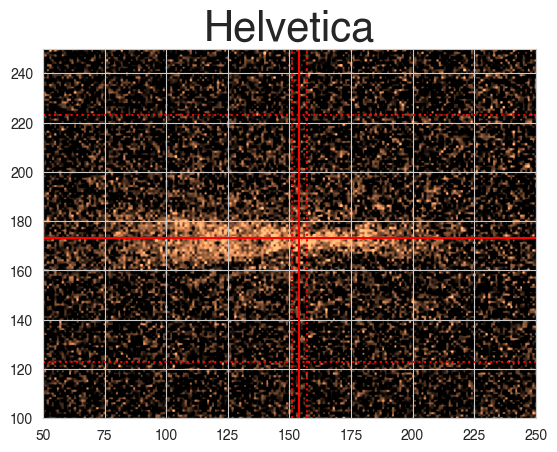

In [7]:
# determine optimal ROI
center = (173, 154)
h = 50
w = 3

rcParams['font.family'] = 'Helvetica'

single_prc = la.density_builder([images_raw[300]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

plt.title("Helvetica", fontsize = 30)

plt.xlim(50, 250)
plt.ylim(100, 250)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")


plt.show()

In [8]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 2531/2531 [100%] in 9:41.7 (4.35/s)  
CPU times: total: 4min
Wall time: 9min 41s


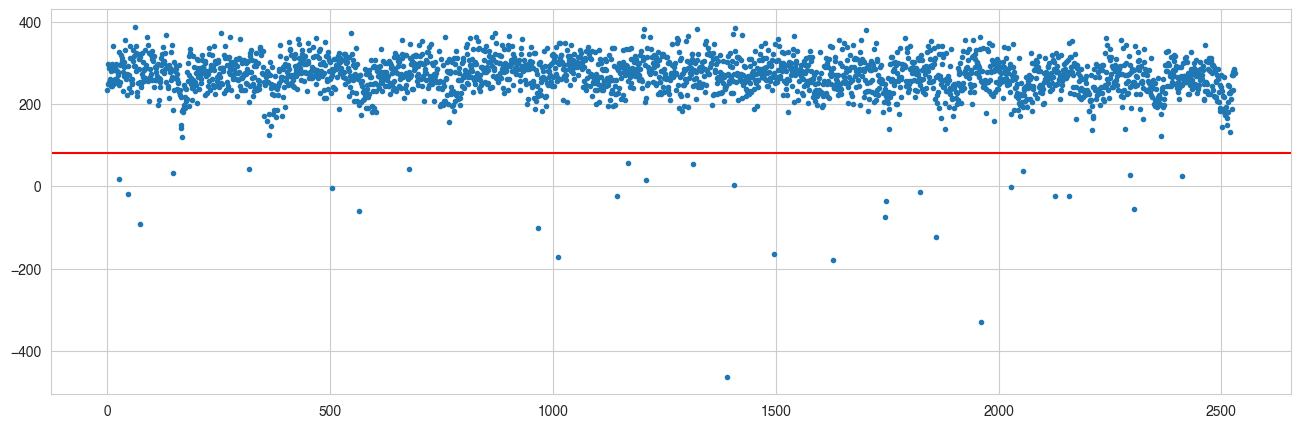

2531


In [46]:
# filter out missed shots
bol = []

for val in var_vals[1]:
    for val2 in var_vals[2]:

        mask = (np.isclose(images_prc["FB_12"], val) &
                np.isclose(images_prc["Acc_heat_freq"], val2))

        for i, im in images_prc[mask].iterrows():
            bol.append(np.sum(im["density"].compressed()))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(80, c = "r")

plt.ylim(None, None)

plt.show()

print(len(bol))

In [10]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 80)

CPU times: total: 375 ms
Wall time: 383 ms


In [11]:
%%time
# group by loop variables and average over iterations
images_grp = la.group(images_fil, variables, "i", info_sorted["Csat"], info_sorted["Img_Illumination_Time"])

MULTI MODE
CPU times: total: 3min 14s
Wall time: 4min 42s


In [112]:
%%time
# make T4 fits 
images_fit = la.T4_fit(images_grp)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [113]:
field = 0

val = 0.8
val2 = 14

T4_list = []

mask = (np.isclose(images_prc["Vcrit_Lattice_Constant"], val) &
        np.isclose(images_prc["Vcrit_Freq_Diff_kHz"], val2))

for i, im in images_prc[mask].iterrows():

    T4 = np.mean(im["density"], axis = 1).compressed()
    pos = np.arange(0, len(T4))
    plt.plot(pos, T4, color = "lightgrey")

    T4_list.append(T4)

T4_fit = np.mean(T4_list, axis = 0)
pos = np.arange(0, len(T4_fit))
plt.plot(pos, T4_fit)

T4_run = la.running_average(T4_fit, 7)
plt.plot(pos, T4_run)

# plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), images_fit["T4_params"].iloc[field][0],
#                                                           images_fit["T4_params"].iloc[field][1],
#                                                           images_fit["T4_params"].iloc[field][2],
#                                                           images_fit["T4_params"].iloc[field][3],
#                                                           images_fit["T4_params"].iloc[field][4],))

plt.show()

print(images_fit["T4_peak"][field])

KeyError: 'Vcrit_Lattice_Constant'

In [12]:
# %%time
# ref_raw = eh.createImageInfoList([ref_dir], ref_variables)
# # print("RAW DONE")
# ref_prc = la.density_builder(ref_raw, ref_variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)
# # print("DENSITY DONE")
# ref_fil = la.filter(ref_prc, 80)
# # print("FILTER DONE")
# ref_grp = la.group(ref_fil, ref_variables, "i", info_sorted["Csat"], info_sorted["Img_Illumination_Time"])
# # print("GROUP DONE")
# ref_fit = la.T4_fit(ref_grp)
# # print("FIT DONE")

In [13]:
def response(images, ref, ref_value, index, column):
    """
    Function:
        This function calculates the response from the T4 peaks extracted
        from both fitting and running average methods.

    Arguments:
        images  -- {pandas dataframe} densities for all combinations of loop variables plus T4 peaks
        index   -- {string} loop variable on y-axis
        index_0 -- {float} value with respect to which the response is calculated

    Returns:
        {pandas dataframe} additionally containing response from T4 peaks
    """

    images_res = images.sort_values(by = [index, column])

    a = np.array(images_res["T4_run_peak"])

    if np.shape(images) != np.shape(ref):
        print("Separate dataset for reference")
        a0  = np.tile(ref["T4_run_peak"], len(images_res) // len(ref["T4_run_peak"]))
    else:
        print("Same dataset for reference")
        mask = np.less_equal(images_res[index], ref_value)
        b = np.array(images_res[mask].groupby([column]).mean(numeric_only = False).reset_index()["T4_run_peak"])
        a0  = np.tile(b, len(images_res) // len(b))

    images_res["response"] = a0 / a - np.ones(len(a))

    return images_res

In [14]:
%%time
# calculate response
images_res = response(images_grp, images_grp, 1000, index = "Acc_heat_freq", column = "FB_12")

Same dataset for reference
CPU times: total: 1.38 s
Wall time: 2.16 s


# Visualization

In [67]:
def spectrum(images, index, columns, values, ticknum_x = 1, ticknum_y = 1, decimal_x = "float2", decimal_y = "float2", rescale_x = 1, rescale_y = 1, rotation_x = 0, title = "INSERT TITLE HERE", xlabel = "X LABEL", ylabel = "Y LABEL", vmin = 0, vmax = 1, cmap = "viridis"):
    """
    Function:
        This function visualizes the response as a function of all loop variables in a heatmap.

    Arguments:
        images  -- {pandas dataframe, containing respsonse from T4 peaks
        index   -- {string} loop variable on y-axis
        columns -- {string} loop variable on x-axis
        values  -- {string} heatmap values (usually response)
        title   -- {string} title of the heatmap
        vmin    -- {scalar} lower bound of colormap
        vmax    -- {scalar} upper bound of colormap
        cmap    -- {string} colormap name

    Returns:
        {matplotlib axis} heatmap of response
    """

    # turn dataframe into heatmap shape
    heat = images.pivot(index = index, columns = columns, values = values)

    # true values (3.5, 2.5)
    # plt.figure(figsize = (3.5, 2.5), edgecolor = "black")

    ax = plt.axes()

    # plot heatmap
    seaborn.heatmap(heat, ax = ax, vmin = vmin, vmax = vmax, cmap = cmap).invert_yaxis()

    ax.set_title(f"{title}", pad = 13, fontsize = 20)
    ax.set_xlabel(f"{xlabel}", fontsize = 7)
    ax.set_ylabel(f"{ylabel}", fontsize = 7)

    # x ticks
    x_ticks = np.arange(0.5, len(heat.columns) + 0.5)[0::ticknum_x]
    x_int = [f"{x/rescale_x:.0f}" for x in heat.columns[0::ticknum_x]]
    x_float1 = [f"{x/rescale_x:.1f}" for x in heat.columns[0::ticknum_x]]
    x_float2 = [f"{x/rescale_x:.2f}" for x in heat.columns[0::ticknum_x]]

    if decimal_x == "int":
        ax.set_xticks(x_ticks, x_int, rotation = rotation_x, fontsize = 7)
    elif decimal_x == "float1":
        ax.set_xticks(x_ticks, x_float1, rotation = rotation_x, fontsize = 7)
    elif decimal_x == "float2":
        ax.set_xticks(x_ticks, x_float2, rotation = rotation_x, fontsize = 7)

    # y ticks
    y_ticks = np.arange(0.5, len(heat.index) + 0.5)[0::ticknum_y]
    y_int = [f"{y/rescale_y:.0f}" for y in heat.index[0::ticknum_y]]
    y_float1 = [f"{y/rescale_y:.1f}" for y in heat.index[0::ticknum_y]]
    y_float2 = [f"{y/rescale_y:.2f}" for y in heat.index[0::ticknum_y]]

    if decimal_y == "int":
        ax.set_yticks(y_ticks, y_int, rotation = 0, fontsize = 7)
    elif decimal_y == "float1":
        ax.set_yticks(y_ticks, y_float1, rotation = 0, fontsize = 7)
    elif decimal_y == "float2":
        ax.set_yticks(y_ticks, y_float2, rotation = 0, fontsize = 7)

    ax.tick_params(axis = "both", colors = "black", direction = "out")

    # for spine in ax.spines.values():
    #     spine.set_visible(True)
    #     spine.set_color("black")

    # cbar = plt.colorbar()  # Assuming you have a colorbar object
    # cbar.outline.set_visible(True)

    plt.draw()

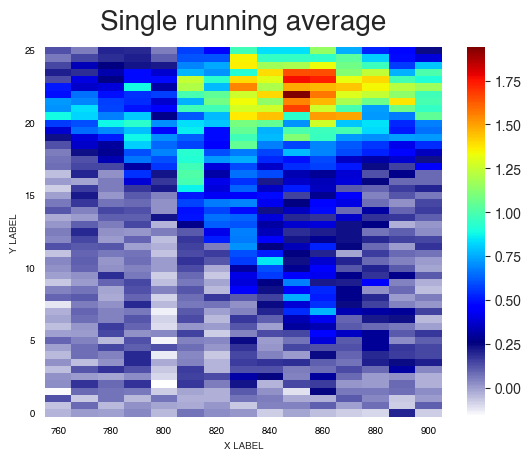

In [68]:
#Greiner map
greiner_data = {'red': ((0., 1, 1,), (.2, 0, 0), (.48, 0, 0), (.728, 1, 1), (0.912, 1, 1), (1, .5, .5)),
                'green': ((0., 1, 1), (.2, 0, 0), (.3, 0, 0), (.5, 1, 1), (.712, 1, 1), (.928, 0, 0), (1, 0, 0)),
                'blue': ((0., 1, 1), (.2, .5, .5), (.288, 1, 1), (.472, 1, 1), (.72, 0, 0), (1, 0, 0))}
                # 'blue': ((0., 1, 1), (0., .8, .8), (0., .6, .6), (0., .4, .4), (0., .2, .2), (0., .0, .0))}

greiner = LinearSegmentedColormap('greiner',greiner_data)

cmap = greiner

spectrum(images_res, "Acc_heat_freq", "FB_12", "response",
         ticknum_x = 2,
         ticknum_y = 10,
         decimal_x = "int",
         decimal_y = "int",
         rescale_x = 1,
         rescale_y = 1e3,
         rotation_x = 0,
         title = "Single running average",
         vmin = None,
         vmax = None,
         cmap = cmap)

In [42]:
def lorentzian(x, a, b, c, d):

    return a * c / (const.pi * ((x-b)**2 + c**2)) + d

In [80]:
def slice(images, index, columns, values, exclude):

    slices = []
    opt = []
    err = []

    heat = images.pivot(index = index, columns = columns, values = values)

    for slice_val in heat.columns:
        if slice_val not in exclude:

            slice = heat[slice_val]

            slices.append(slice)
            popt, pcov = curve_fit(lorentzian, heat.index, slice, p0 = [1, 18, 1, 0.1])

            opt.append(popt)
            err.append(np.sqrt(np.diag(pcov)))

    return slices, np.array(opt), np.array(err)

In [83]:
slices, popt, perr = slice(images_res, index = variables[2], columns = variables[1], values = "response", exclude = [0.7])

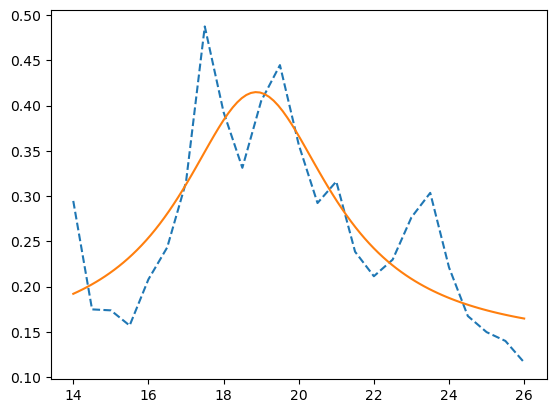

In [87]:
field = 0

x = np.linspace(14, 26, 100)

plt.plot(slices[field], ls = "--")
plt.plot(x, lorentzian(x, *popt[field]))
plt.show()

ValueError: 'x' and 'y' must have the same size

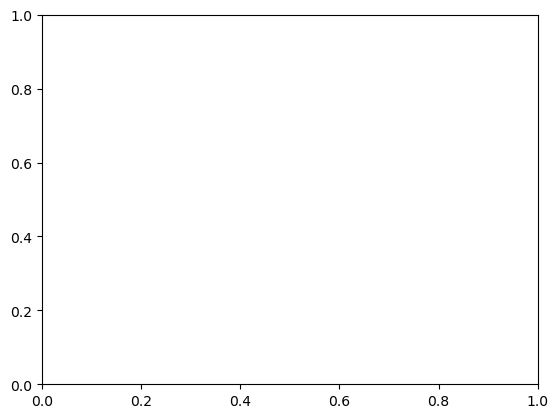

In [85]:
x = var_vals[1].copy()

plt.errorbar(x, popt[:, 1], perr[:, 1], marker = ".", ms = 15, lw = 1, ls = "--", elinewidth = 1, capsize = 5)
plt.errorbar()
plt.show()

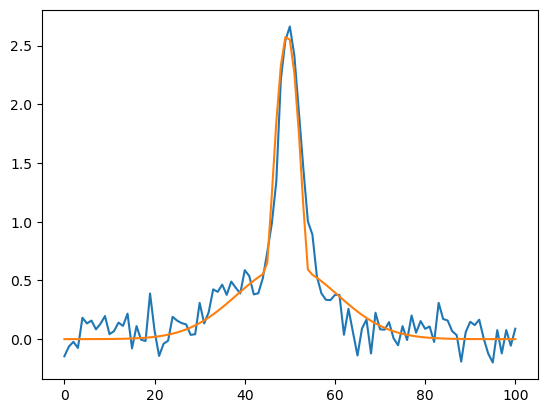

[6.528140828263473, 1.1211825723640065]


In [118]:
field = 0

T4 = np.mean(images_fit["density"].iloc[field], axis = 1).compressed()
pos = np.arange(0, len(T4))

plt.plot(pos, T4)

plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), images_fit["T4_params"].iloc[field][0],
                                                          images_fit["T4_params"].iloc[field][1],
                                                          images_fit["T4_params"].iloc[field][2],
                                                          images_fit["T4_params"].iloc[field][3],
                                                          images_fit["T4_params"].iloc[field][4],))

# plt.plot(pos, parab(pos, 2.3, 50, 5))

plt.show()

print(images_fit["temperature"].iloc[field])

In [30]:
# for i, im in images_fit.iterrows():
#
#     T4 = np.mean(im["density"], axis = 1).compressed()
#     pos = np.arange(0, len(T4))
#
#     plt.plot(pos, T4)
#
#     plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), im["T4_params"][0],
#                                                               im["T4_params"][1],
#                                                               im["T4_params"][2],
#                                                               im["T4_params"][3],
#                                                               im["T4_params"][4],), label = f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK")
#
#     # plt.axhline(im["T4_params"][0] + im["T4_params"][3], color = "grey", ls = "--")
#     plt.axhline(im["T4_peak"], color = "grey", ls = "--")
#
#     plt.legend(loc = 1)
#
#     plt.show()
#
#     # print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK @ {im["FB_Img"]:.0f} G")
#     print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK")
#     print(im["T4_params"])
#     print("")

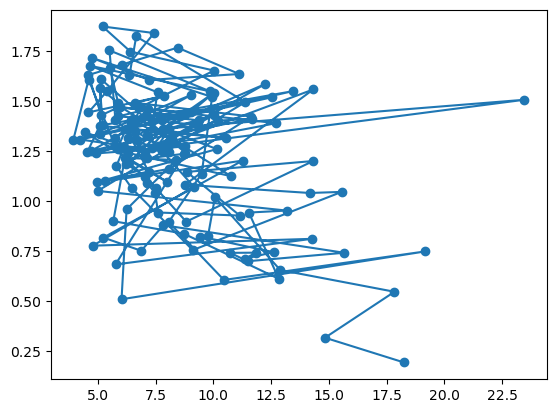

In [31]:
peeeek = []
TTT = []

for i, im in images_fit.iterrows():
    peeeek.append(im["T4_params"][-2])
    TTT.append(im["temperature"][0])

plt.scatter(TTT, peeeek)
plt.plot(TTT, peeeek)

plt.show()


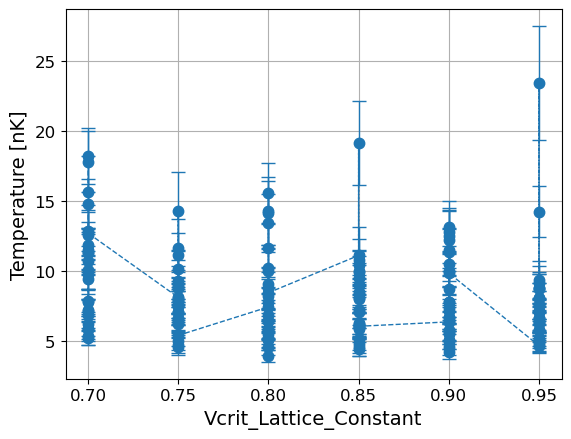

In [32]:
x = np.array(images_fit["Vcrit_Lattice_Constant"].tolist())
y = np.array(images_fit["temperature"].tolist())

plt.errorbar(x, y[:, 0], y[:, 1], marker = ".", ms = 15, lw = 1, ls = "--", elinewidth = 1, capsize = 5)

plt.xlabel(f"{variables[1]}", fontsize = 14)
plt.ylabel("Temperature [nK]", fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid(visible = True, which = "both")

plt.show()